In [1]:
#!git clone https://github.com/navpreetsingh9/main-repo-era.git

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import argparse

from models.resnet import ResNet18, ResNet34
from utils.dataset import means, stds, class_map, Cifar10SearchDataset
from utils.transforms import CustomResnetTransforms
from utils.utils import show_images, print_summary, get_incorrect_predictions, denormalize_image
from utils.utils import plot_incorrect_predictions, plot_network_performance, show_gradcam
from utils.train import train, test, get_sgd_optimizer, get_adam_optimizer, get_onecyclelr_scheduler, get_lr_finder
from utils.train import train_losses, test_losses, train_acc, test_acc

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda = torch.cuda.is_available()
print("CUDA Available?", torch.cuda.is_available())
seed = 100
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

CUDA Available? True


In [3]:
# Hyperparameters

batch_size = 256
lr = 0.03
weight_decay = 5e-4
use_scheduler = True
end_lr = 10
epochs = 20

In [4]:
# Data
print('==> Preparing data..')
train_transforms = CustomResnetTransforms.train_transforms(means, stds)
test_transforms = CustomResnetTransforms.test_transforms(means, stds)

train_dataset = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test_dataset = Cifar10SearchDataset(root='./data', train=False,
                                    download=True, transform=test_transforms)

dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4,
                        pin_memory=True) if cuda else dict(shuffle=True, batch_size=batch_size)

train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


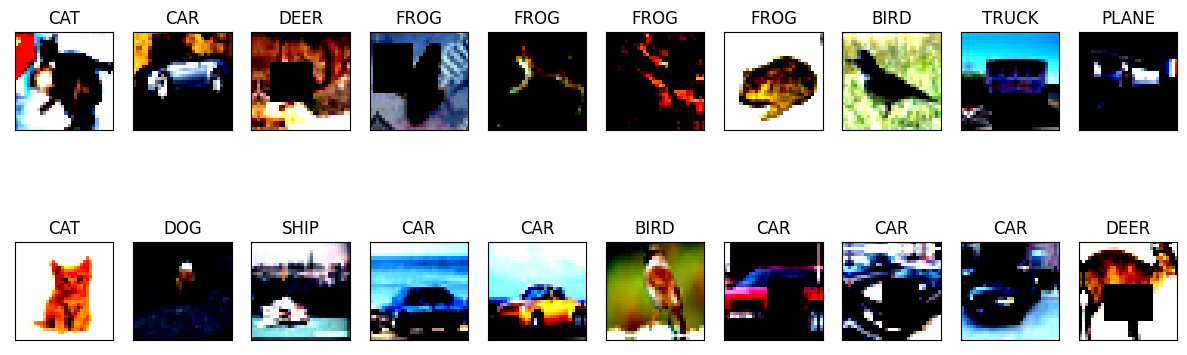

In [5]:
show_images(train_loader, class_map, count=20)

In [6]:
# Model
print('==> Building model..')
model = ResNet18().to(device)
print_summary(model, (1, 3, 36, 36)) # With padding=4

==> Building model..


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 36, 36]           1,728
├─BatchNorm2d: 1-2                       [1, 64, 36, 36]           128
├─Sequential: 1-3                        [1, 64, 36, 36]           --
│    └─BasicBlock: 2-1                   [1, 64, 36, 36]           --
│    │    └─Conv2d: 3-1                  [1, 64, 36, 36]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 36, 36]           128
│    │    └─Conv2d: 3-3                  [1, 64, 36, 36]           36,864
│    │    └─BatchNorm2d: 3-4             [1, 64, 36, 36]           128
│    │    └─Sequential: 3-5              [1, 64, 36, 36]           --
│    └─BasicBlock: 2-2                   [1, 64, 36, 36]           --
│    │    └─Conv2d: 3-6                  [1, 64, 36, 36]           36,864
│    │    └─BatchNorm2d: 3-7             [1, 64, 36, 36]           

==> Initializing optimizer and scheduler..


 64%|██████▍   | 128/200 [00:18<00:10,  6.86it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.38E-02


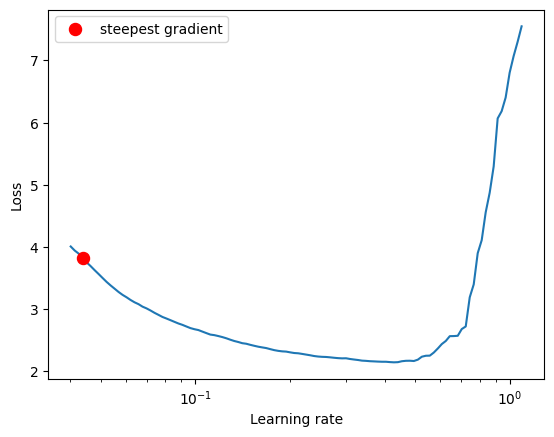

In [7]:
print('==> Initializing optimizer and scheduler..')
criterion = nn.CrossEntropyLoss()
optimizer = get_adam_optimizer(model, lr=lr, weight_decay=weight_decay)

if use_scheduler:
    max_lr = get_lr_finder(model, optimizer, criterion, device, train_loader, end_lr)
    scheduler = get_onecyclelr_scheduler(optimizer, max_lr, steps_per_epoch=len(train_loader), epochs=epochs)

In [8]:
print('==> Training the model..')
for epoch in range(1,epochs+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, criterion)
    test(model, device, test_loader, criterion)
    if use_scheduler:
        scheduler.step()

  0%|          | 0/196 [00:00<?, ?it/s]

==> Training the model..
EPOCH: 1


Loss=1.1677879095077515 LR=0.00043846247301313244 Batch_id=195 Accuracy=48.76: 100%|██████████| 196/196 [00:41<00:00,  4.67it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 5504/10000 (55.04%)

EPOCH: 2


Loss=0.8220806121826172 LR=0.00048280137477850536 Batch_id=195 Accuracy=65.04: 100%|██████████| 196/196 [00:41<00:00,  4.70it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 6647/10000 (66.47%)

EPOCH: 3


Loss=0.8978415727615356 LR=0.0005271402765438783 Batch_id=195 Accuracy=72.41: 100%|██████████| 196/196 [00:42<00:00,  4.58it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 6470/10000 (64.70%)

EPOCH: 4


Loss=0.805041491985321 LR=0.0005714791783092512 Batch_id=195 Accuracy=76.29: 100%|██████████| 196/196 [00:42<00:00,  4.58it/s] 
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 7209/10000 (72.09%)

EPOCH: 5


Loss=0.6297289133071899 LR=0.0006158180800746242 Batch_id=195 Accuracy=78.94: 100%|██████████| 196/196 [00:42<00:00,  4.57it/s] 
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 7080/10000 (70.80%)

EPOCH: 6


Loss=0.5766252279281616 LR=0.0006601569818399972 Batch_id=195 Accuracy=80.40: 100%|██████████| 196/196 [00:42<00:00,  4.66it/s] 
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 7726/10000 (77.26%)

EPOCH: 7


Loss=0.5418388247489929 LR=0.0007044958836053702 Batch_id=195 Accuracy=81.76: 100%|██████████| 196/196 [00:42<00:00,  4.66it/s] 
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 7883/10000 (78.83%)

EPOCH: 8


Loss=0.4841400980949402 LR=0.0007488347853707431 Batch_id=195 Accuracy=82.63: 100%|██████████| 196/196 [00:41<00:00,  4.69it/s] 
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 7388/10000 (73.88%)

EPOCH: 9


Loss=0.2318219244480133 LR=0.000793173687136116 Batch_id=195 Accuracy=83.58: 100%|██████████| 196/196 [00:42<00:00,  4.61it/s] 
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 8212/10000 (82.12%)

EPOCH: 10


Loss=0.5560305714607239 LR=0.0008375125889014889 Batch_id=195 Accuracy=84.31: 100%|██████████| 196/196 [00:42<00:00,  4.56it/s] 
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 7913/10000 (79.13%)

EPOCH: 11


Loss=0.5630502104759216 LR=0.0008818514906668619 Batch_id=195 Accuracy=84.70: 100%|██████████| 196/196 [00:42<00:00,  4.60it/s] 
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 7283/10000 (72.83%)

EPOCH: 12


Loss=0.5037320852279663 LR=0.0009261903924322348 Batch_id=195 Accuracy=85.19: 100%|██████████| 196/196 [00:43<00:00,  4.51it/s] 
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 7287/10000 (72.87%)

EPOCH: 13


Loss=0.4134144186973572 LR=0.0009705292941976078 Batch_id=195 Accuracy=85.99: 100%|██████████| 196/196 [00:42<00:00,  4.60it/s] 
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 7810/10000 (78.10%)

EPOCH: 14


Loss=0.6398171186447144 LR=0.0010148681959629808 Batch_id=195 Accuracy=85.72: 100%|██████████| 196/196 [00:42<00:00,  4.66it/s] 
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 8237/10000 (82.37%)

EPOCH: 15


Loss=0.5879635214805603 LR=0.0010592070977283538 Batch_id=195 Accuracy=86.25: 100%|██████████| 196/196 [00:41<00:00,  4.67it/s] 
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 8341/10000 (83.41%)

EPOCH: 16


Loss=0.6118032932281494 LR=0.0011035459994937265 Batch_id=195 Accuracy=86.49: 100%|██████████| 196/196 [00:42<00:00,  4.63it/s] 
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 8163/10000 (81.63%)

EPOCH: 17


Loss=0.5050179958343506 LR=0.0011478849012590995 Batch_id=195 Accuracy=86.98: 100%|██████████| 196/196 [00:43<00:00,  4.52it/s] 
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 7715/10000 (77.15%)

EPOCH: 18


Loss=0.3456317186355591 LR=0.0011922238030244725 Batch_id=195 Accuracy=87.04: 100%|██████████| 196/196 [00:42<00:00,  4.62it/s] 
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 8182/10000 (81.82%)

EPOCH: 19


Loss=0.5049136877059937 LR=0.0012365627047898455 Batch_id=195 Accuracy=87.21: 100%|██████████| 196/196 [00:42<00:00,  4.58it/s] 
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 8257/10000 (82.57%)

EPOCH: 20


Loss=0.428802490234375 LR=0.0012809016065552185 Batch_id=195 Accuracy=87.23: 100%|██████████| 196/196 [00:42<00:00,  4.61it/s]  



Test set: Average loss: 0.0019, Accuracy: 8411/10000 (84.11%)



==> Finished Training..


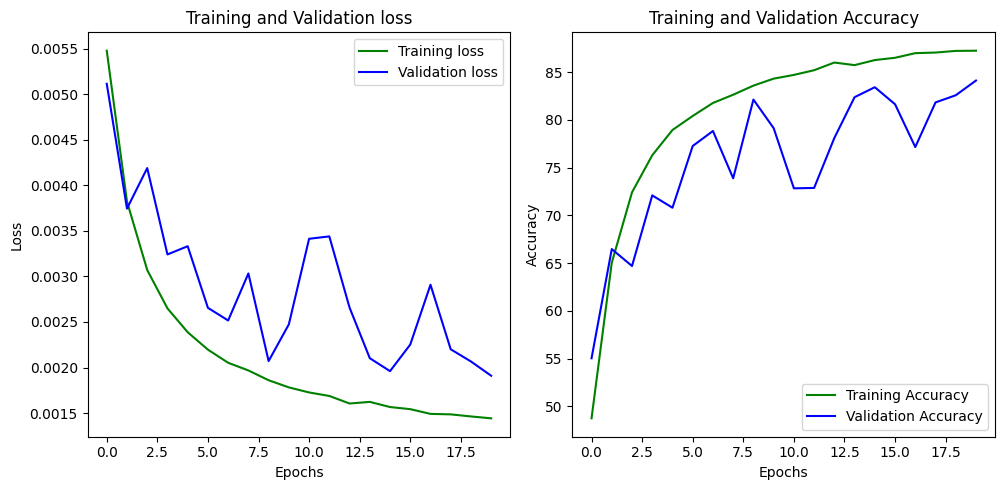

In [9]:
print('==> Finished Training..')
plot_network_performance(epochs, train_losses, test_losses, train_acc, test_acc)

Total Incorrect Predictions 1589


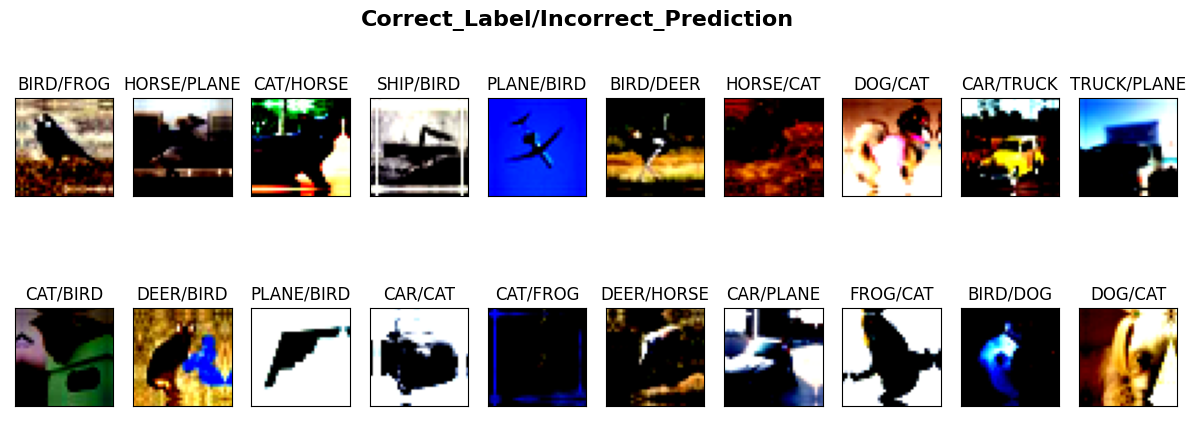

In [10]:
incorrect = get_incorrect_predictions(model, test_loader, device)
plot_incorrect_predictions(incorrect, class_map, count=20)

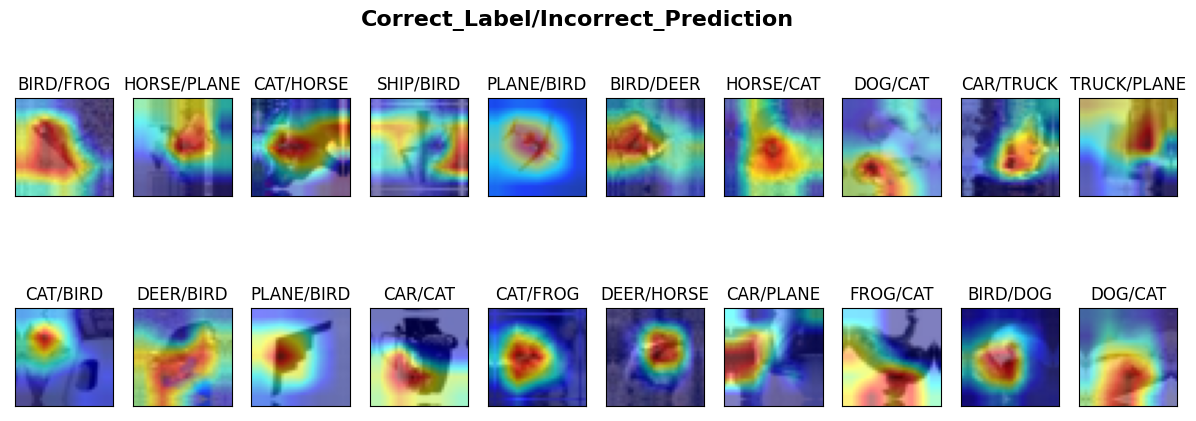

In [11]:
show_gradcam(model, incorrect, class_map, cuda, means, stds, count=20)